# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [1]:
import pandas as pd
import numpy as np

In [2]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [3]:
!pip install rs-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.4 MB/s eta 0:00:00


In [4]:
from rs_datasets import MovieLens

In [5]:
data = MovieLens("1m")
data.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 9.90MB/s]                           


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [7]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [8]:
import matplotlib.pyplot as plt

In [9]:
ratings = data.ratings
users = data.users
items = data.items

# Анализ взаимодействия пользователей

## Года взаимодействий

In [14]:
times = ratings['timestamp']

In [15]:
years = list(map(lambda x : x.year , times))

In [16]:
cnts = pd.Series(years).value_counts()

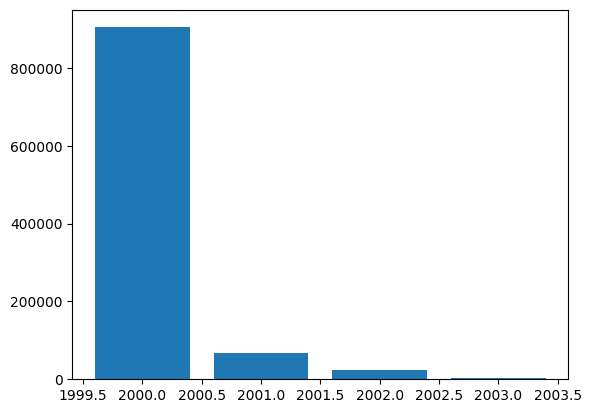

In [17]:
plt.bar(cnts.index , cnts.values)
plt.show()

* Распределение как будто специально сделано в качестве последовательности во времени train test val


## Общее распределение средних оценок по пользователям

In [18]:
avg_rates =  ratings.groupby('user_id')['relevance'].mean()

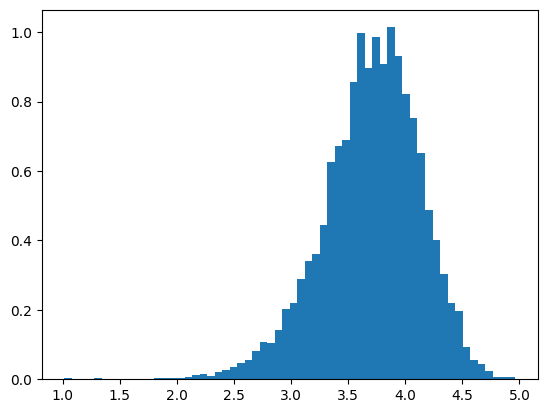

In [19]:
plt.hist(avg_rates, bins=60, density=True)
plt.show()

## Активность пользователей

In [20]:
activity = ratings.groupby('user_id')['item_id'].count()

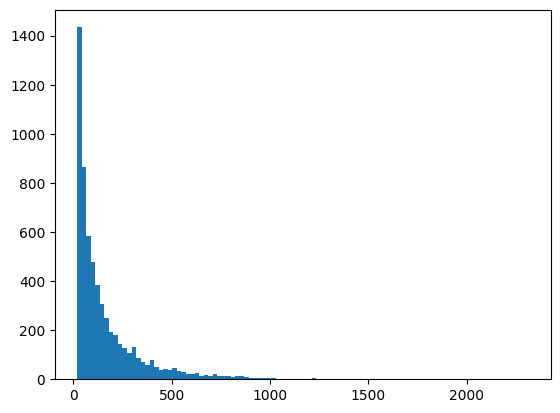

In [22]:
plt.hist(activity , bins = 100 , density=False)
plt.show()

* Очень похоже на показательное распределение

* Есть люди, которые оценивали до 1400 айтемов

## Популярность айтемов

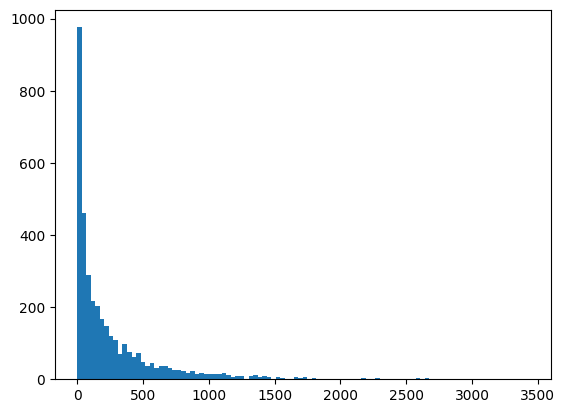

In [33]:
popularity = ratings.groupby('item_id')['user_id'].count()
plt.hist(popularity , bins = 100 , density=False)
plt.show()

## Средний рейтинг айтемов

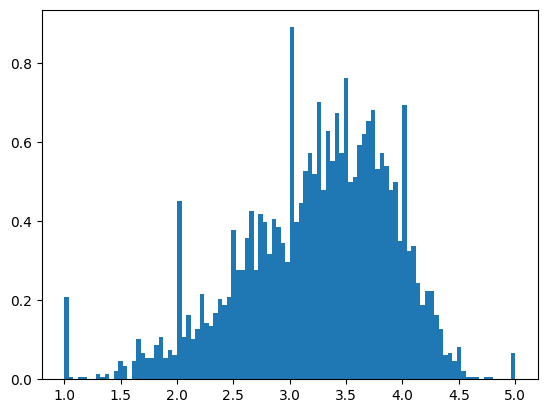

In [37]:
mean_relevance = ratings.groupby('item_id')['relevance'].mean()
plt.hist(mean_relevance , bins = 100 , density=True)
plt.show()

## Распределение длительности взаимодейтсвий пользователей

In [23]:
time_activity = ratings.groupby('user_id')['timestamp']

In [24]:
delta_time = time_activity.max() - time_activity.min()

In [25]:
delta_time.head(1)

user_id
1   6 days 01:38:52
Name: timestamp, dtype: timedelta64[ns]

In [26]:
times = np.array(list(map(lambda x : x.astype(np.timedelta64(1,'D')).astype(np.int64) , delta_time.values )))

In [27]:
len(times[times == 0 ])/len(times)

0.6293046357615895

* 62 % пользователей в совокупности пользуются продуктом не дольше дня
* Остальных пользователей можно считать активными пользователями

In [28]:
np.quantile(times , q = [0.63 , 0.65 , 0.7 ,0.8 ,0.9 , 0.95])

array([  1.  ,   1.  ,   6.  ,  65.  , 429.3 , 729.05])

* У 30 %  пользователей активность больше недели

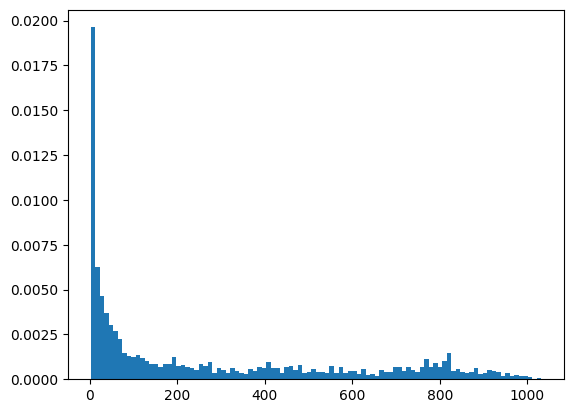

In [29]:
plt.hist(times[times > 1] , bins= 100 , density=True )
plt.show()

* По сути для анализа рекомендаций нужны активные пользователи с активностью более недели.
* Но информацию о малоактивных пользователях можно использовать для понимания, как привлечь этих пользователей,то есть сделать активными. И также можно понять, почему они не стали активными.
* По графику можно предположить, что около половины из тех 30 % перестают оставлять рейтинг фильмам через 100 дней.

* Но дальше распределение времени "активности" можно аппроксимировать равномерным

# Анализ пользователей

## Распределение возраста

In [25]:
ages = users.groupby('age')['user_id'].count()

In [26]:
set(users['age'].values)

{1, 18, 25, 35, 45, 50, 56}

<BarContainer object of 7 artists>

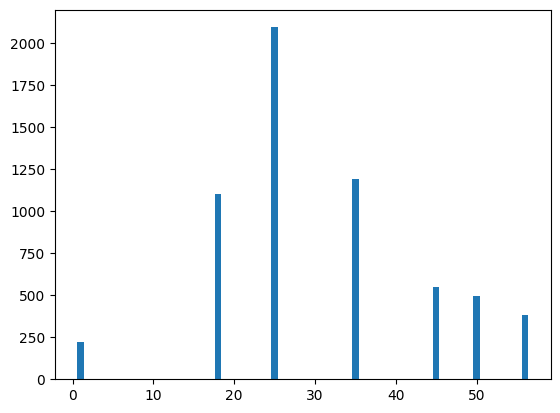

In [27]:
plt.bar(ages.index , ages.values )

* Очень странное распределение возраста, будто авторы аппроксимируют возраста пользователей на сетку из нескольких значений возрастов

## Распределение активности юзеров и

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [38]:
data.ratings.shape , data.users.shape , data.items.shape

((1000209, 4), (6040, 5), (3883, 3))

In [39]:
get_log_info(data.ratings)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


In [40]:
data.ratings.keys()

Index(['user_id', 'item_id', 'relevance', 'timestamp'], dtype='object')

In [41]:
# YOUR CODE HERE
ratings = data.ratings
train = ratings[ratings['timestamp'] < np.datetime64('2000-12-01')]
val = ratings[np.datetime64('2000-12-01') <= ratings['timestamp']][ ratings['timestamp'] <= np.datetime64('2000-12-31')][ratings['relevance'] > 3]
val = val[val['user_id'].isin(train['user_id'].values) ]

<ipython-input-41-c387f200dade>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val = ratings[np.datetime64('2000-12-01') <= ratings['timestamp']][ ratings['timestamp'] <= np.datetime64('2000-12-31')][ratings['relevance'] > 3]


In [42]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [43]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [44]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [45]:
%%time
# YOUR CODE HERE
K = 20
items_id = data.items['item_id'].unique()
users_id = val['user_id'].unique()
random_pred = []
for j in range(K):
  random_pred+= [ [u , np.random.choice(items_id) , 1 ] for u in users_id]

random_pred = pd.DataFrame(random_pred , columns = ['user_id' , 'item_id' , 'relevance'])


CPU times: user 256 ms, sys: 3.72 ms, total: 260 ms
Wall time: 270 ms


In [46]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [47]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,3651,1


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [48]:
# %pip install surprise

In [49]:
import math


In [50]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    # YOUR CODE HERE
    gt = row['gt_list']
    if k > len(gt):
        k = len(gt)
    r = row['pred_list'][:k]
    value = np.zeros(k)
    for i,j in enumerate(r) :
        if j in gt :
            value[i] = 1
        else :
            value[i] = 0
    if len(gt) == 0 :
        return 0
    return (value/np.log2(1+ np.arange(1,k+1))).sum() / (1/np.log2(1 + np.arange(1,k+1))).sum()


In [51]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [52]:
from copy import deepcopy

In [53]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3
def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    # print('2')
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    # print('3')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    # print('4')
    # print(to_compare.head(2))
    # return to_compare
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

def ndcg(preds , val , k) :
    wrapped_mean , wrapped =metric_wrap(preds , val , k = k , metric_by_user=lambda x : ndcg_user(x , k = k) )
    return wrapped_mean



In [54]:
ndcg(random_pred , val, k = 4)

0.006943314933036356

### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [55]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        # YOUR CODE HERE
        self.selfInformation = -np.log2(log.groupby('item_id')['user_id'].nunique() / log['user_id'].nunique() )
        self.selfInfocold = -np.log2(1 / log['user_id'].nunique() )
        self.N = log['user_id'].nunique()
        self.items = log['item_id'].unique()
        # self.log = log
    def __call__(self, pred, k):
        # YOUR CODE HERE
        result = 0
        # print(pred.shape[0])
        if 'pred_list' in pred.keys():
            result = 0
            for item in pred['pred_list'] :
                if item in self.items :
                    result += self.selfInformation[item]
                else :
                    result += self.selfInfocold
            return result / k /np.log2(self.N)
        else :
            u_2_index = pred.groupby('user_id')['item_id'].apply(lambda x : sorted(x.index  , key = lambda i : -pred.loc[i ,'relevance'])).reset_index(name='items').values
        # print(u_2_index)
        for u_i in u_2_index :
            for i in u_i[1][:k] :
                item = pred['item_id'][i]
                if item in self.items :
                    result += self.selfInformation[item]
                else :
                    result += self.selfInfocold

        return result / k /np.log2(self.N)/len(u_2_index)

In [56]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [57]:
from copy import deepcopy

def user_hr(row ):
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0


def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

def measure(pred, true, name, metrics_hist=None, cov_items=None , surp_train=None , K= 5):
    if metrics_hist is None:
        metrics_hist = pd.DataFrame(columns=['hit_rate@K', 'coverage@K'])
    metrics_hist.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]

    if cov_items is not None:
        metrics_hist.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    metrics_hist.loc[name, 'ndcg@K'] = ndcg(preds=pred,val=true , k=K)
    if surp_train is not None :
        surp = Surprisal(surp_train)
        metrics_hist.loc[name, 'surprisal@K'] = metric_wrap(pred=pred , ground_truth=true , k= K , metric_by_user=lambda x : surp(x , k =K) )[0]
    return metrics_hist

In [58]:
metrics = measure(random_pred, val, 'PopRec', cov_items=train['item_id'].drop_duplicates())
metrics.sort_values('hit_rate@K', ascending=False)

,hit_rate@K,coverage@K,ndcg@K
PopRec,0.030651,0.493173,0.006786


In [59]:
# YOUR CODE HERE: оценка 4 метрик для рекомендаций из задания 3

measure(random_pred  , val , 'RandomPred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20)



,hit_rate@K,coverage@K,ndcg@K,surprisal@K
RandomPred,0.114943,0.935827,0.006867,0.528001


## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

In [60]:
! pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.5 MB/s eta 0:00:00


# 1)

In [61]:
from implicit.nearest_neighbours import CosineRecommender
from scipy.sparse import csr_matrix, coo_matrix

In [62]:
train_matrix = coo_matrix((train['relevance'].astype(np.float64) , (train['user_id'] , train['item_id'])))

In [63]:
user_items = train_matrix.tocsr()

In [64]:
cosine_metrics = []

user_idx = val['user_id'].unique()
N_range = [1,2,3,5,10,15,20]
for N in N_range :
    model = CosineRecommender(K=N)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    cosine_preds = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            cosine_preds.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    cosine_preds = pd.DataFrame(cosine_preds)
    cosine_metrics.append(measure(cosine_preds  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20))

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0069811344146728516 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007021903991699219 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.013821125030517578 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.014060258865356445 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03314352035522461 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.013811826705932617 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0072820186614990234 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

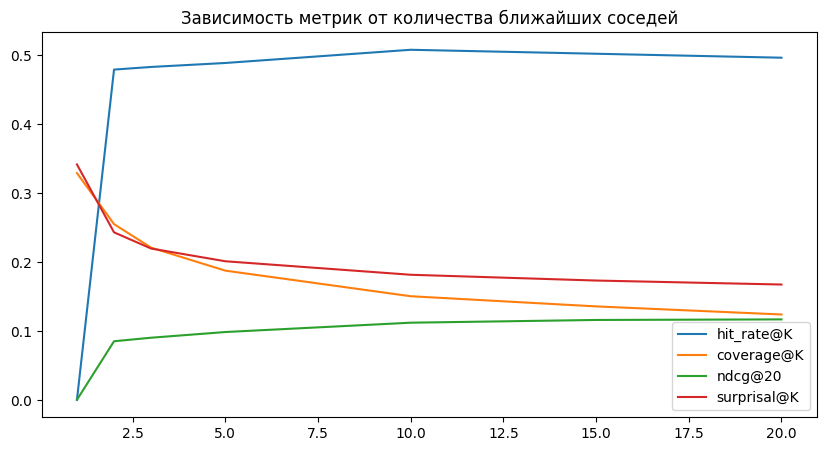

In [88]:
plt.figure(figsize=(10,5))
plt.plot(N_range , np.array(cosine_metrics).reshape(7,4), label = ['hit_rate@K' ,'coverage@K','ndcg@20','surprisal@K' ] )
# plt.plot(N_range , [ i['ndcg@K'] for i in cosine_metrics]  , label='ndcg@20 при разных K')
plt.legend()
plt.title('Зависимость метрик от количества ближайших соседей')
plt.show()

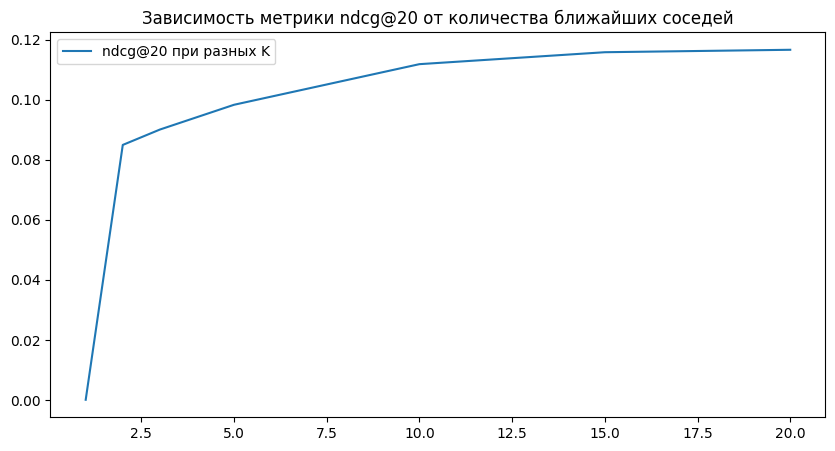

In [89]:
plt.figure(figsize=(10,5))
plt.plot(N_range , [ i['ndcg@K'] for i in cosine_metrics]  , label='ndcg@20 при разных K')
plt.legend()
plt.title('Зависимость метрики ndcg@20 от количества ближайших соседей')
plt.show()

## Сравнение с рандомным предсказанием

In [83]:
cosine_measure = measure(cosine_preds  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20)
measure(random_pred  , val , 'RandomPred' , cov_items=train['item_id'].drop_duplicates() ,metrics_hist = cosine_measure, surp_train = train , K=20)

,hit_rate@K,coverage@K,ndcg@K,surprisal@K
CosinePred,0.496169,0.123703,0.116589,0.167176
RandomPred,0.114943,0.935827,0.006867,0.528001


## 2)

## Применим tf-idf взвешивание
* Tf -- частота слова в каждом документе
* idf -- логарифм отношения числа документов к числу документа где слово встречается

* Интерпретируем слово -- как user
* А документ -- как  item

* tf(user,item) * idf(user)  - такой вес умножаем на relevance[user,item]
* idf -- характеризует непопулярность айтема
* tf  -- характеризует важность оценки user-а по отношению к item-у по сравнению с остальными (по сути нормировка relevance вдоль оси user)

* У TFIDFRecommender нет гиперпараметров , кроме числа соседей (как и у Cosine)

In [84]:
from implicit.nearest_neighbours import TFIDFRecommender

In [85]:
cosine_tfidf_metrics = []

user_idx = val['user_id'].unique()
for N in N_range :

    model = TFIDFRecommender(K=N)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    cosine_preds_tfidf = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            cosine_preds_tfidf.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    cosine_preds_tfidf = pd.DataFrame(cosine_preds_tfidf)
    cosine_tfidf_metrics.append(measure(cosine_preds_tfidf  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20))

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00622868537902832 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007444620132446289 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006172895431518555 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0064275264739990234 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006675004959106445 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006296634674072266 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0061457157135009766 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

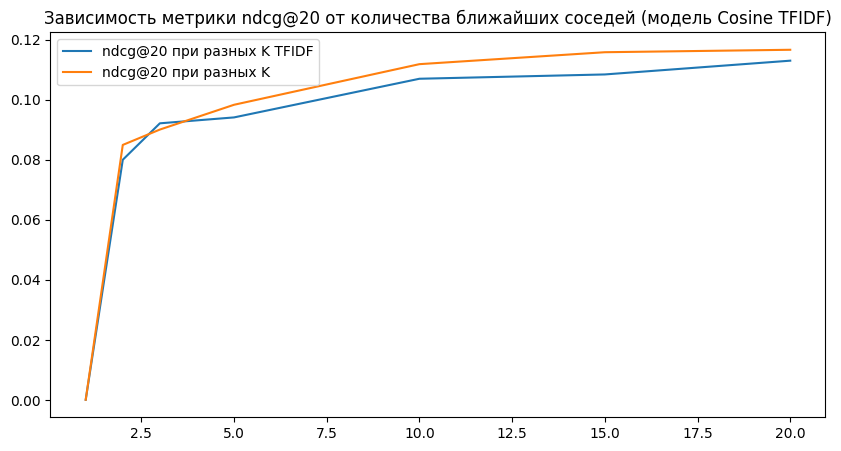

In [87]:
plt.figure(figsize=(10,5))
# plt.plot(N_range , np.array(cosine_tfidf_metrics).reshape(7,4), label = ['hit_rate@K tfidf' ,'coverage@K tfidf','ndcg@20 tfidf','surprisal@K tfidf' ] )
# plt.plot(N_range , np.array(cosine_metrics).reshape(7,4), label = ['hit_rate@K' ,'coverage@K','ndcg@20','surprisal@K' ] )
plt.plot(N_range , [ i['ndcg@K'] for i in cosine_tfidf_metrics]  , label='ndcg@20 при разных K TFIDF')
plt.plot(N_range , [ i['ndcg@K'] for i in cosine_metrics]  , label='ndcg@20 при разных K')
plt.legend()
plt.title('Зависимость метрики ndcg@20 от количества ближайших соседей (модель Cosine TFIDF)')
plt.show()

* TFIDF показал даже хуже значения , чем у Cosine

# 3)
* Обрежем датасет по relevance > 3
* Не будем предсказывать просмтренные айтемы (везде и так по дефолту такое стоит)

In [105]:
cut_train = train[train['relevance'] > 3]
train_matrix = coo_matrix((cut_train['relevance'].astype(np.float64) , (cut_train['user_id'] , cut_train['item_id'])))
user_items = train_matrix.tocsr()

In [106]:
cosine_tfidf_metrics_cuttrain = []

user_idx = val['user_id'].unique()
for N in N_range :
    model = TFIDFRecommender(K=N)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    cosine_preds_tfidf = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            cosine_preds_tfidf.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    cosine_preds_tfidf = pd.DataFrame(cosine_preds_tfidf)
    cosine_tfidf_metrics_cuttrain.append(measure(cosine_preds_tfidf  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20))

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004462480545043945 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004017353057861328 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003452777862548828 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004093170166015625 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003664255142211914 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004432201385498047 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00421595573425293 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

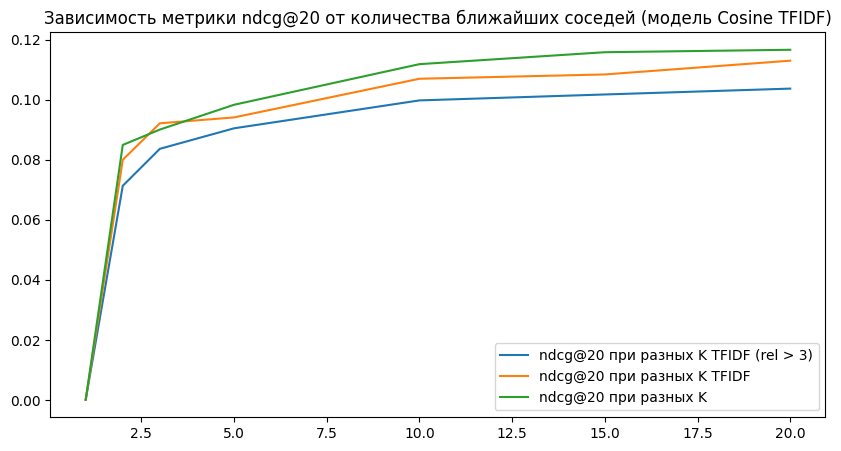

In [107]:
plt.figure(figsize=(10,5))
plt.plot(N_range , [ i['ndcg@K'] for i in cosine_tfidf_metrics_cuttrain]  , label='ndcg@20 при разных K TFIDF (rel > 3)')

plt.plot(N_range , [ i['ndcg@K'] for i in cosine_tfidf_metrics]  , label='ndcg@20 при разных K TFIDF')
plt.plot(N_range , [ i['ndcg@K'] for i in cosine_metrics]  , label='ndcg@20 при разных K')

plt.legend()
plt.title('Зависимость метрики ndcg@20 от количества ближайших соседей (модель Cosine TFIDF)')
plt.show()

* Качество упало при обрезании relevance > 3
* Информация об отрицательном взаимодействии является важной

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

# 1)

## подберем гиперпараметры

In [92]:
from implicit.als import AlternatingLeastSquares

In [87]:
train.shape , val.shape

((791270, 4), (14790, 4))

In [133]:
train_1 = ratings[ratings['timestamp'] < np.datetime64('2000-09-01')]
train_2 = ratings[np.datetime64('2000-09-01') <= ratings['timestamp']][ ratings['timestamp'] <= np.datetime64('2000-12-01')][ratings['relevance'] > 3]
train_2 = train_2[train_2['user_id'].isin(train_1['user_id'].values) ]

<ipython-input-133-7b30838c329f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_2 = ratings[np.datetime64('2000-09-01') <= ratings['timestamp']][ ratings['timestamp'] <= np.datetime64('2000-12-01')][ratings['relevance'] > 3]


In [134]:
train_1.shape , train_2.shape

((405762, 4), (10558, 4))

In [135]:
train_matrix = coo_matrix((train_1['relevance'].astype(np.float64) , (train_1['user_id'] , train_1['item_id'])))
user_items = train_matrix.tocsr()

In [136]:
reg_metrics = []

user_idx = train_2['user_id'].unique()
reg_range = [1,10,100,1000,2000]
for reg in reg_range :
    model = AlternatingLeastSquares(factors=7 , regularization=reg)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    preds = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            preds.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    preds = pd.DataFrame(preds)
    reg_metrics.append(measure(preds  , train_2 , 'CosinePred' , cov_items=train_1['item_id'].drop_duplicates() , surp_train = train_1 , K=20))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [137]:
print(reg_range , [i['ndcg@K'].values[0] for i in reg_metrics])

[1, 10, 100, 1000, 2000] [0.12186209803775062, 0.11734134359857268, 0.1297677989347336, 0.12036251424034736, 0.12034675908686146]


In [138]:
reg_range[np.argmax([i['ndcg@K'].values[0] for i in reg_metrics])]

100

* Оптимлаьный параметр регуляризации считаем равным 100

In [93]:
train_matrix = coo_matrix((train['relevance'].astype(np.float64) , (train['user_id'] , train['item_id'])))
user_items = train_matrix.tocsr()

## Используем оптимальный параметр регуляризации

In [94]:
als_metrics = []

user_idx = val['user_id'].unique()
factors_range = [1,2,3,5,10,15,20]
for factor in factors_range :
    model = AlternatingLeastSquares(factors=factor, regularization=100)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    preds = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            preds.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    preds = pd.DataFrame(preds)
    als_metrics.append(measure(preds  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20))

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

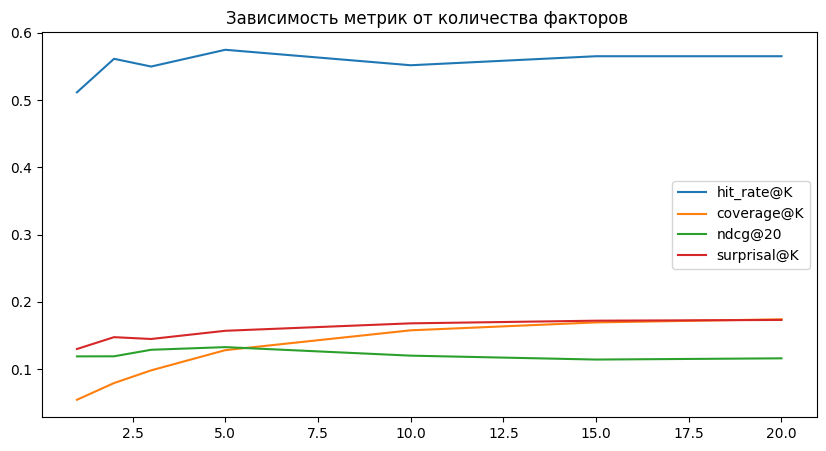

In [95]:
plt.figure(figsize=(10,5))
# plt.plot(factors_range , [ i['ndcg@K'] for i in als_metrics]  , label='ndcg@20 при разных факторах')
plt.plot(factors_range , np.array(als_metrics).reshape(7,4), label = ['hit_rate@K' ,'coverage@K','ndcg@20','surprisal@K' ] )

plt.legend()
plt.title('Зависимость метрик от количества факторов ')
plt.show()

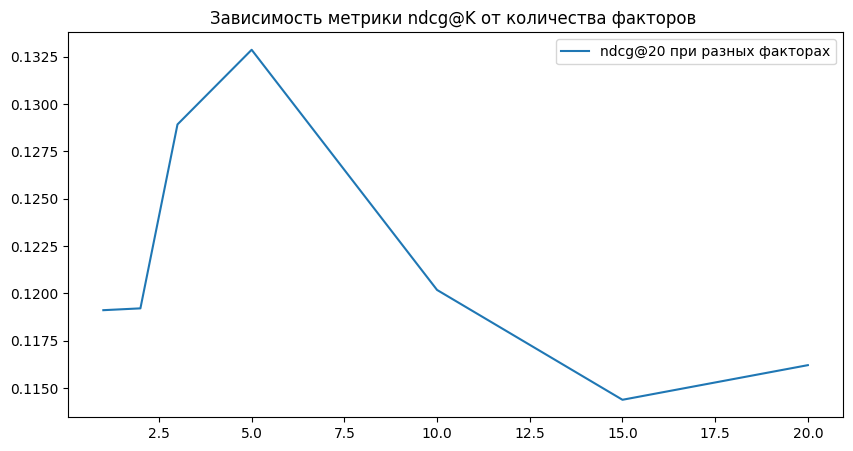

In [96]:
plt.figure(figsize=(10,5))
plt.plot(factors_range , [ i['ndcg@K'] for i in als_metrics]  , label='ndcg@20 при разных факторах')

plt.legend()
plt.title('Зависимость метрики ndcg@K от количества факторов ')
plt.show()

* Регуляризация сильно уменьшила влияние факторов на качества

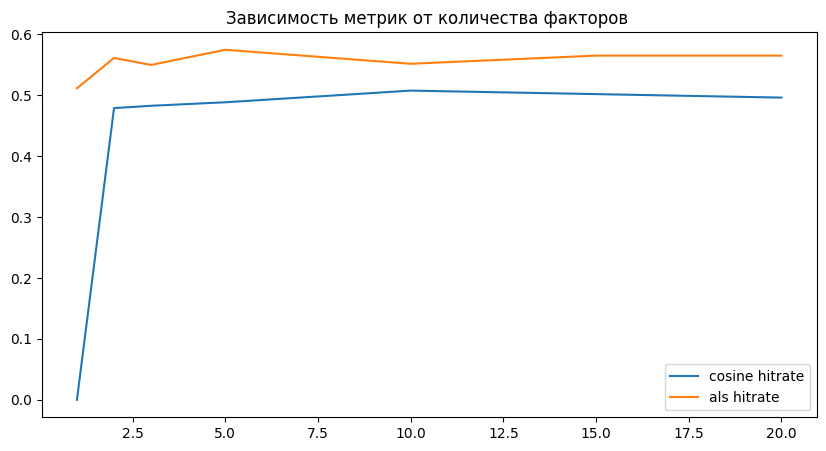

In [97]:
plt.figure(figsize=(10,5))
plt.plot(factors_range , [ i['hit_rate@K'] for i in cosine_metrics]  , label='cosine hitrate')
plt.plot(factors_range , [ i['hit_rate@K'] for i in als_metrics]  , label='als hitrate')

# plt.plot(factors_range , np.array(als_metrics).reshape(7,4), label = ['hit_rate@K' ,'coverage@K','ndcg@20','surprisal@K' ] )

plt.legend()
plt.title('Зависимость метрик от количества факторов ')
plt.show()

* hitrate у als заметно лучше, чем у Cosine

# 2)

In [98]:
cut_train = train[train['relevance'] > 3]
train_matrix = coo_matrix((cut_train['relevance'].astype(np.float64) , (cut_train['user_id'] , cut_train['item_id'])))
user_items = train_matrix.tocsr()

In [144]:
als_metrics_cuttrain = []

user_idx = val['user_id'].unique()
factors_range = [1,2,3,5,10,15,20]
for factor in factors_range :
    model = AlternatingLeastSquares(factors=factor, regularization=100)
    model.fit(user_items)
    recs = model.recommend(userid=user_idx,user_items=user_items[user_idx] , N=20, filter_already_liked_items=True)
    preds = []
    for i in range(len(user_idx)) :
        for j in range(len(recs[0][i])) :
            preds.append({'user_id' : user_idx[i] , 'item_id' : recs[0][i][j], 'relevance' : recs[1][i][j]})
    preds = pd.DataFrame(preds)
    als_metrics_cuttrain.append(measure(preds  , val , 'CosinePred' , cov_items=train['item_id'].drop_duplicates() , surp_train = train , K=20))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

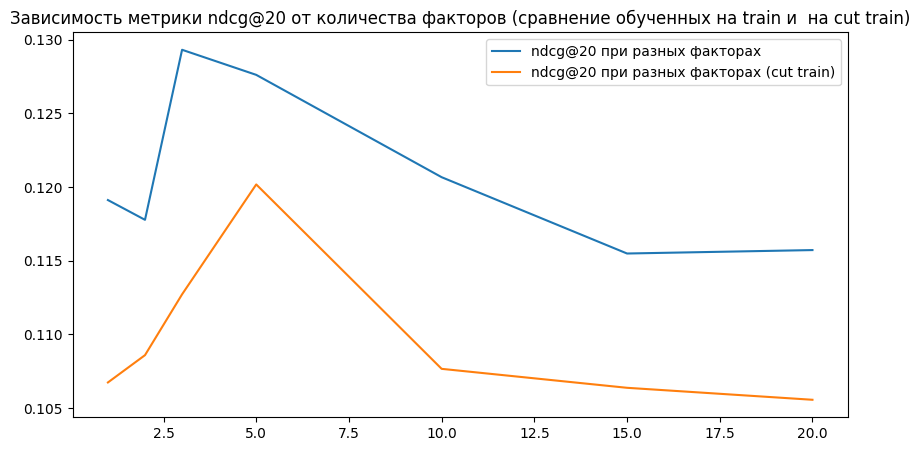

In [145]:
plt.figure(figsize=(10,5))
plt.plot(factors_range , [ i['ndcg@K'] for i in als_metrics]  , label='ndcg@20 при разных факторах')
plt.plot(factors_range , [ i['ndcg@K'] for i in als_metrics_cuttrain]  , label='ndcg@20 при разных факторах (cut train)')

plt.legend()
plt.title('Зависимость метрики ndcg@20 от количества факторов (сравнение обученных на train и  на cut train)')
plt.show()

* Снова видим , что качество падает, что подтверждает, что важно знать так же отрицательные взаимодействия

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

1. Модель cosine -- выдает скоры ndcg и hitrate значительно больше чем у рандомного предсказания
2. Модель als -- заметно обгоняет cosine по этим же метрикам
3. Обрезание информации об отрицательных взаимодействиям ухудшает качество ndcg (в моделях als ,cosine)
4. Использование TFIDF для als ухудшило качество ndcg
5. Использование регуляризации в als подавляет влияние числа факторов на метрики (то есть als сильно чувтсвителен к настройке гиперпараметров)
6. Модели als,cosine проигрывают рандомному предсказанию по метрикам recall,surprisal. За счет случайности рандомайзер покрывает большое число айтемов (пробивает recall), в том числе рекомендует непопулярные айтемы (surprisal). Но модели cosine,als настариваются скорее на популярные айтемы, чем на редко используемые.

* Так и не понял зачем нам другие части датасета  data.user ,data.item их что тоже надо было использовать ??
* Очень сложно было понять какой формат данных нужно загонять в модели в 5 задании и как пользоваться model.recommend. Кажется нужно в семинарах какой-то пример с подобной моделью сделать.